In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width: 100% !important; }</style>"))

## Twitter Disaster prediction

https://www.kaggle.com/c/nlp-getting-started/overview

**Goal :** Predict whether a tweet is about real disaster or not!

In [122]:
import pandas as pd 
import numpy as np 
import opendatasets as od 
import os
from datetime import datetime 

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgbm
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score

In [5]:
def setup_data_repo (URL):
    '''
    Provide the URL to any kaggle competition and let this method setup the
    data repository for you.

    '''
    od.download(URL, force=True)
    p_name = URL.split('/')[-1]
    my_data_dir = os.listdir("./"+p_name)
    for file in my_data_dir:
        if file.endswith(".zip"):
            with ZipFile (p_name+"/"+file) as zip:
                zip.extractall(path=p_name)
    for file in my_data_dir :
        if file.endswith(".zip"):
            complete_path = os.path.join(dir_name, file)
            os.remove(complete_path)
    return print('\033[1m'+f'Folder "{p_name}" now contains these files : {os.listdir(p_name)}'+'\033[0m')

In [4]:
setup_data_repo(URL="https://kaggle.com/c/nlp-getting-started")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: hasanainmehmood
Your Kaggle Key: ········


  0%|                                                                                       | 0.00/593k [00:00<?, ?B/s]

100%|███████████████████████████████████████████████████████████████████████████████| 593k/593k [00:00<00:00, 2.15MB/s]


Extracting archive .\nlp-getting-started/nlp-getting-started.zip to .\nlp-getting-started
Folder "nlp-getting-started" now contains these files : ['sample_submission.csv', 'test.csv', 'train.csv']


In [89]:
train = pd.read_csv('./nlp-getting-started/train.csv', index_col='id')
test = pd.read_csv('./nlp-getting-started/test.csv', index_col='id')
train

,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...
10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1


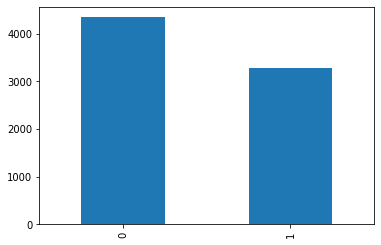

In [90]:
train['target'].value_counts().plot(kind='bar');

In [91]:
y = train.pop('target')

In [92]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7613 entries, 1 to 10873
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   keyword   7552 non-null   object
 1   location  5080 non-null   object
 2   text      7613 non-null   object
dtypes: object(3)
memory usage: 237.9+ KB


In [93]:
(train.isna().sum()/train.shape[0])*100

keyword      0.801261
location    33.272035
text         0.000000
dtype: float64

In [94]:
train.location.nunique() #This won't be of any use

3341

In [95]:
train.keyword.nunique() #This could be useful

221

In [96]:
train.keyword.unique()

array([nan, 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'der

In [97]:
train['keyword'] = train['keyword'].str.replace('%20', " ").fillna('')

test['keyword'] = test['keyword'].str.split('20%', " ").fillna("")
test.head(3)

,keyword,location,text
id,,,
0,,NaN,Just happened a terrible car crash
2,,NaN,"Heard about #earthquake is different cities, s..."
3,,NaN,"there is a forest fire at spot pond, geese are..."


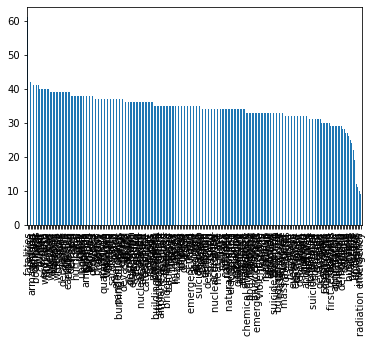

In [64]:
train['keyword'].value_counts().plot(kind='bar');

In [98]:
import re 
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner', 'textcat'])
stop_words = [word.lemma_.lower() for word in nlp(' '.join(nlp.Defaults.stop_words))]
def lemmatizer(text):
    text = re.sub('&amp;', '&', text)
    return [ word.lemma_.lower().strip() for word in nlp(text) if word.pos_ not in ['PUNCT', 'SYM', 'X']
            and word.lemma_[0] != '@' and word.lemma_ != '#' and word.lemma_ != '&'  and (not word.lemma_.startswith('http'))]
for row in train.sample(20).itertuples():
    print(row.text)
    print(lemmatizer(row.text))

JKL cancels Flash Flood Warning for Bell Harlan Knox [KY]  http://t.co/4rY6zhcPOQ #WX
['jkl', 'cancel', 'flash', 'flood', 'warn', 'for', 'bell', 'harlan', 'knox', '', 'wx']
ÛÏ@SplottDave: @TeamPalestina That's about 28700 Palestinian homes demolished now by Israel since 1967 w/ 0 Israeli home demolished @POTUS
['that', 'be', 'about', '28700', 'palestinian', 'home', 'demolish', 'now', 'by', 'israel', 'since', '1967', 'w/', '0', 'israeli', 'home', 'demolish']
@Doylech They're refugees: 'people who have been forced to leave their country in order to escape war persecution or natural disaster'
['they', 'be', 'refugee', 'people', 'who', 'have', 'be', 'force', 'to', 'leave', 'their', 'country', 'in', 'order', 'to', 'escape', 'war', 'persecution', 'or', 'natural', 'disaster']
Have you read this awesome book yet?  The Two Trillion Dollar Meltdown  http://t.co/jPA6sajFE3
['have', 'you', 'read', 'this', 'awesome', 'book', 'yet', '', 'the', 'two', 'trillion', 'dollar', 'meltdown', '']
#news Cram

In [99]:
train.keyword.unique() 

array(['', 'ablaze', 'accident', 'aftershock', 'airplane accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown up', 'body bag', 'body bagging', 'body bags',
       'bomb', 'bombed', 'bombing', 'bridge collapse',
       'buildings burning', 'buildings on fire', 'burned', 'burning',
       'burning buildings', 'bush fires', 'casualties', 'casualty',
       'catastrophe', 'catastrophic', 'chemical emergency', 'cliff fall',
       'collapse', 'collapsed', 'collide', 'collided', 'collision',
       'crash', 'crashed', 'crush', 'crushed', 'curfew', 'cyclone',
       'damage', 'danger', 'dead', 'death', 'deaths', 'debris', 'deluge',
       'deluged', 'demolish', 'demolished', 'demolition', 'derail',
       'derailed', 'derailment', 'desola

In [100]:
X_train, X_test , y_train, y_test = train_test_split(train, y, test_size=0.2, random_state=42)
X_train.shape, y_train.shape, X_test.shape,  y_test.shape

((6090, 3), (6090,), (1523, 3), (1523,))

In [68]:
from joblib import Memory
memory = Memory(location='cachedir') # this cached transformed data will be for gridsearch

In [74]:
#LogisticRegression
pipe = GridSearchCV( 
    Pipeline([
    ('features', ColumnTransformer([                 #ColumnTransformer would combine all the transformations applied on columns, just like a feature uninion
        ('tweet_text', TfidfVectorizer(tokenizer=lemmatizer, stop_words = stop_words, ngram_range=(1,2)), 'text'),
        ('keyword', TfidfVectorizer(tokenizer=lemmatizer), 'keyword')
    ])),
    ('classifier', LogisticRegression(max_iter=300))
], memory=memory), cv=5, param_grid = {'classifier__C':np.logspace(-3,2,10)}
)

In [118]:
#RandomForestClassifier

pipe = GridSearchCV( 
    Pipeline([
    ('features', ColumnTransformer([              
        ('tweet_text', TfidfVectorizer(tokenizer=lemmatizer, stop_words = stop_words, ngram_range=(1,2)), 'text'),
        ('keyword', TfidfVectorizer(tokenizer=lemmatizer), 'keyword')
    ])),
    ('classifier', lgbm.LGBMClassifier())
], memory=memory), cv=5, param_grid = {'classifier__max_depth':range(6,11), 'classifier__n_estimators':np.linspace(200,500,3)}
)

In [119]:
pipe.fit(X_train, y_train)

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(ColumnTransformer(transformers=[('tweet_text',
                                 TfidfVectorizer(ngram_range=(1, 2),
                                                 stop_words=['former', 'up',
                                                             'be', 'sometime',
                                                             'whereupon',
                                                             'make', 'do',
                                                             'hers', 'behind',
                                                             'use', 'n’t',
                                                             'top', 'since',
                                                ..., 
                keyword                        location  \
id                                                        
7241   natural disas

C:\Users\92304\AppData\Roaming\Python\Python37\site-packages\sklearn\feature_extraction\text.py:391: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['‘'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


_______________________________________________fit_transform_one - 20.6s, 0.3min


C:\Users\92304\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\92304\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\92304\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\92304\AppData\Roaming\Python\Python37\site-packages\lightgbm\sklearn.py", line 895, in fit
    callbacks=callbacks, init_model=init_model)
  File "C:\Users\92304\AppData\Roaming\Python\Python37\site-packages\lightgbm\sklearn.py", line 688, in fit
    callbacks=callbacks, init_model=init_model)
  File "C:\Users\92304\AppData\Roaming\Python\Python37\site-p

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(ColumnTransformer(transformers=[('tweet_text',
                                 TfidfVectorizer(ngram_range=(1, 2),
                                                 stop_words=['former', 'up',
                                                             'be', 'sometime',
                                                             'whereupon',
                                                             'make', 'do',
                                                             'hers', 'behind',
                                                             'use', 'n’t',
                                                             'top', 'since',
                                                ..., 
            keyword                        location  \
id                                                    
7128       military         

C:\Users\92304\AppData\Roaming\Python\Python37\site-packages\sklearn\feature_extraction\text.py:391: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['‘'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


_______________________________________________fit_transform_one - 20.6s, 0.3min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(ColumnTransformer(transformers=[('tweet_text',
                                 TfidfVectorizer(ngram_range=(1, 2),
                                                 stop_words=['former', 'up',
                                                             'be', 'sometime',
                                                             'whereupon',
                                                             'make', 'do',
                                                             'hers', 'behind',
                                                             'use', 'n’t',
                                                             'top', 'since',
                                                ..., 
            keyword                        location  \
id

C:\Users\92304\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\92304\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\92304\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\92304\AppData\Roaming\Python\Python37\site-packages\lightgbm\sklearn.py", line 895, in fit
    callbacks=callbacks, init_model=init_model)
  File "C:\Users\92304\AppData\Roaming\Python\Python37\site-packages\lightgbm\sklearn.py", line 688, in fit
    callbacks=callbacks, init_model=init_model)
  File "C:\Users\92304\AppData\Roaming\Python\Python37\site-p

_______________________________________________fit_transform_one - 20.4s, 0.3min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(ColumnTransformer(transformers=[('tweet_text',
                                 TfidfVectorizer(ngram_range=(1, 2),
                                                 stop_words=['former', 'up',
                                                             'be', 'sometime',
                                                             'whereupon',
                                                             'make', 'do',
                                                             'hers', 'behind',
                                                             'use', 'n’t',
                                                             'top', 'since',
                                                ..., 
            keyword                        location  \
id

C:\Users\92304\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\92304\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\92304\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\92304\AppData\Roaming\Python\Python37\site-packages\lightgbm\sklearn.py", line 895, in fit
    callbacks=callbacks, init_model=init_model)
  File "C:\Users\92304\AppData\Roaming\Python\Python37\site-packages\lightgbm\sklearn.py", line 688, in fit
    callbacks=callbacks, init_model=init_model)
  File "C:\Users\92304\AppData\Roaming\Python\Python37\site-p

_______________________________________________fit_transform_one - 22.1s, 0.4min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(ColumnTransformer(transformers=[('tweet_text',
                                 TfidfVectorizer(ngram_range=(1, 2),
                                                 stop_words=['former', 'up',
                                                             'be', 'sometime',
                                                             'whereupon',
                                                             'make', 'do',
                                                             'hers', 'behind',
                                                             'use', 'n’t',
                                                             'top', 'since',
                                                ..., 
             keyword                 location  \
id      

C:\Users\92304\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\92304\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\92304\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\92304\AppData\Roaming\Python\Python37\site-packages\lightgbm\sklearn.py", line 895, in fit
    callbacks=callbacks, init_model=init_model)
  File "C:\Users\92304\AppData\Roaming\Python\Python37\site-packages\lightgbm\sklearn.py", line 688, in fit
    callbacks=callbacks, init_model=init_model)
  File "C:\Users\92304\AppData\Roaming\Python\Python37\site-p

_______________________________________________fit_transform_one - 20.9s, 0.3min


C:\Users\92304\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\92304\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\92304\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\92304\AppData\Roaming\Python\Python37\site-packages\lightgbm\sklearn.py", line 895, in fit
    callbacks=callbacks, init_model=init_model)
  File "C:\Users\92304\AppData\Roaming\Python\Python37\site-packages\lightgbm\sklearn.py", line 688, in fit
    callbacks=callbacks, init_model=init_model)
  File "C:\Users\92304\AppData\Roaming\Python\Python37\site-p

C:\Users\92304\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\92304\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\92304\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\92304\AppData\Roaming\Python\Python37\site-packages\lightgbm\sklearn.py", line 895, in fit
    callbacks=callbacks, init_model=init_model)
  File "C:\Users\92304\AppData\Roaming\Python\Python37\site-packages\lightgbm\sklearn.py", line 688, in fit
    callbacks=callbacks, init_model=init_model)
  File "C:\Users\92304\AppData\Roaming\Python\Python37\site-p

C:\Users\92304\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\92304\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\92304\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\92304\AppData\Roaming\Python\Python37\site-packages\lightgbm\sklearn.py", line 895, in fit
    callbacks=callbacks, init_model=init_model)
  File "C:\Users\92304\AppData\Roaming\Python\Python37\site-packages\lightgbm\sklearn.py", line 688, in fit
    callbacks=callbacks, init_model=init_model)
  File "C:\Users\92304\AppData\Roaming\Python\Python37\site-p

C:\Users\92304\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\92304\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\92304\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\92304\AppData\Roaming\Python\Python37\site-packages\lightgbm\sklearn.py", line 895, in fit
    callbacks=callbacks, init_model=init_model)
  File "C:\Users\92304\AppData\Roaming\Python\Python37\site-packages\lightgbm\sklearn.py", line 688, in fit
    callbacks=callbacks, init_model=init_model)
  File "C:\Users\92304\AppData\Roaming\Python\Python37\site-p

C:\Users\92304\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\92304\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\92304\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\92304\AppData\Roaming\Python\Python37\site-packages\lightgbm\sklearn.py", line 895, in fit
    callbacks=callbacks, init_model=init_model)
  File "C:\Users\92304\AppData\Roaming\Python\Python37\site-packages\lightgbm\sklearn.py", line 688, in fit
    callbacks=callbacks, init_model=init_model)
  File "C:\Users\92304\AppData\Roaming\Python\Python37\site-p

C:\Users\92304\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\92304\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\92304\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\92304\AppData\Roaming\Python\Python37\site-packages\lightgbm\sklearn.py", line 895, in fit
    callbacks=callbacks, init_model=init_model)
  File "C:\Users\92304\AppData\Roaming\Python\Python37\site-packages\lightgbm\sklearn.py", line 688, in fit
    callbacks=callbacks, init_model=init_model)
  File "C:\Users\92304\AppData\Roaming\Python\Python37\site-p

C:\Users\92304\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\92304\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\92304\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\92304\AppData\Roaming\Python\Python37\site-packages\lightgbm\sklearn.py", line 895, in fit
    callbacks=callbacks, init_model=init_model)
  File "C:\Users\92304\AppData\Roaming\Python\Python37\site-packages\lightgbm\sklearn.py", line 688, in fit
    callbacks=callbacks, init_model=init_model)
  File "C:\Users\92304\AppData\Roaming\Python\Python37\site-p

C:\Users\92304\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\92304\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\92304\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\92304\AppData\Roaming\Python\Python37\site-packages\lightgbm\sklearn.py", line 895, in fit
    callbacks=callbacks, init_model=init_model)
  File "C:\Users\92304\AppData\Roaming\Python\Python37\site-packages\lightgbm\sklearn.py", line 688, in fit
    callbacks=callbacks, init_model=init_model)
  File "C:\Users\92304\AppData\Roaming\Python\Python37\site-p

C:\Users\92304\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\92304\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\92304\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\92304\AppData\Roaming\Python\Python37\site-packages\lightgbm\sklearn.py", line 895, in fit
    callbacks=callbacks, init_model=init_model)
  File "C:\Users\92304\AppData\Roaming\Python\Python37\site-packages\lightgbm\sklearn.py", line 688, in fit
    callbacks=callbacks, init_model=init_model)
  File "C:\Users\92304\AppData\Roaming\Python\Python37\site-p

C:\Users\92304\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\92304\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\92304\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\92304\AppData\Roaming\Python\Python37\site-packages\lightgbm\sklearn.py", line 895, in fit
    callbacks=callbacks, init_model=init_model)
  File "C:\Users\92304\AppData\Roaming\Python\Python37\site-packages\lightgbm\sklearn.py", line 688, in fit
    callbacks=callbacks, init_model=init_model)
  File "C:\Users\92304\AppData\Roaming\Python\Python37\site-p

C:\Users\92304\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\92304\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\92304\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\92304\AppData\Roaming\Python\Python37\site-packages\lightgbm\sklearn.py", line 895, in fit
    callbacks=callbacks, init_model=init_model)
  File "C:\Users\92304\AppData\Roaming\Python\Python37\site-packages\lightgbm\sklearn.py", line 688, in fit
    callbacks=callbacks, init_model=init_model)
  File "C:\Users\92304\AppData\Roaming\Python\Python37\site-p

C:\Users\92304\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\92304\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\92304\AppData\Roaming\Python\Python37\site-packages\sklearn\pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\92304\AppData\Roaming\Python\Python37\site-packages\lightgbm\sklearn.py", line 895, in fit
    callbacks=callbacks, init_model=init_model)
  File "C:\Users\92304\AppData\Roaming\Python\Python37\site-packages\lightgbm\sklearn.py", line 688, in fit
    callbacks=callbacks, init_model=init_model)
  File "C:\Users\92304\AppData\Roaming\Python\Python37\site-p

C:\Users\92304\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_search.py:925: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  category=UserWarning


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(ColumnTransformer(transformers=[('tweet_text',
                                 TfidfVectorizer(ngram_range=(1, 2),
                                                 stop_words=['former', 'up',
                                                             'be', 'sometime',
                                                             'whereupon',
                                                             'make', 'do',
                                                             'hers', 'behind',
                                                             'use', 'n’t',
                                                             'top', 'since',
                                                ..., 
            keyword                        location  \
id                                                    
7128       military         

C:\Users\92304\AppData\Roaming\Python\Python37\site-packages\sklearn\feature_extraction\text.py:391: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['‘'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


_______________________________________________fit_transform_one - 25.3s, 0.4min


LightGBMError: Parameter num_iterations should be of type int, got "200.0"

In [123]:
predicted_y = pipe.predict(X_test)

AttributeError: 'NoneType' object has no attribute 'predict'

In [120]:
pipe.score(X_train, y_train)

AttributeError: 'GridSearchCV' object has no attribute 'scorer_'

In [106]:
pipe.score(X_test, y_test)

0.6323046618516087

In [107]:
submission = pipe.predict(test)
filetime = datetime.now().strftime("%Y-%m-%d-%H-%m")
submission = pd.DataFrame({'id': test.index, 'target': submission}).set_index('id')
submission.to_csv('Submissions/Submission'+filetime+'.csv')